In [51]:
import matplotlib.pyplot as plt
import numpy as np
import math


def f(x):
    return 3*x**2 - 4*x + 5

In [52]:
f(3.0)

20.0

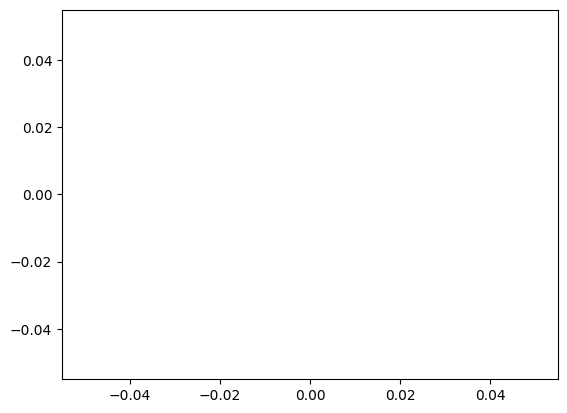

In [53]:
x5 = np.arange(-5, -5, 0.25)
y5 = f(x5)
plt.plot(x5, y5)

In [54]:
h = 0.00001
x = 2 / 3
( f(x + h) - f(x) )/ h

3.0000002482211127e-05

In [55]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [56]:
d1 = a*b + c
b += h
d2 = a*b + c

print('d1:', d1)
print('d2:', d2)
print('slope:', (d2 - d1) / h)

d1: 4.0
d2: 4.00002
slope: 2.0000000000131024


In [76]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1 * out.grad
            other.grad += 1 * out.grad
        out._backward = _backward
        return out

    def __radd__(self, other):
        return self.__add__(other)

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def __rmul__(self, other):
        return self.__mul__(other)

    def __pow__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data ** other.data, (self, ), f"**{other.data}")
        def _backward():
            self.grad += other.data * self.data ** (other.data - 1) * out.grad

        out._backward = _backward
        return out

    def __truediv__(self, other):
        return self * (other**-1)

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def __rsub__(self, other):
        return other + (-self)

    def tanh(self):
        n = self.data
        t = (math.exp(n) - math.exp(-n)) / (math.exp(n) + math.exp(-n))
        out = Value(t, (self,), 'tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out

    def exp(self):
        out = Value(math.exp(self.data), (self,), 'exp')
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out

    def backward(self):
        self.grad = 1.0
        topo =[]
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self) # build topological order

        for node in reversed(topo):
            node._backward()

In [77]:
a = Value(2.0)
b = Value(-3.0)
a / b

Value(data=-0.6666666666666666)

In [78]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node (name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [79]:
def lol():

    h = 0.0001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L

    a = Value(2.0 + h, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L

    print((L1.data - L2.data) / h)
lol()

6.000000000021544


In [80]:
a = Value(2.0 + h, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(2.0, label='f')
L = d * f; L.label = 'L'

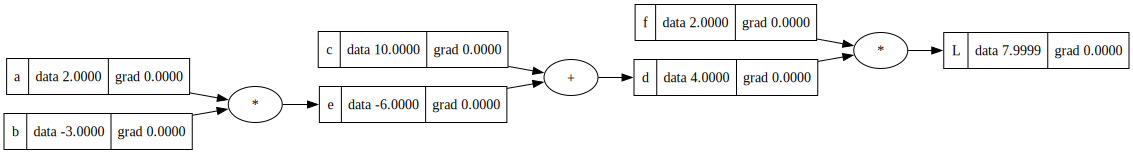

In [81]:
draw_dot(L)

In [82]:
L.grad = 1.0
d.grad = L.grad * f.data
f.grad = L.grad * d.data
e.grad = d.grad * 1
c.grad = d.grad * 1
b.grad = e.grad * a.data
a.grad = e.grad * b.data

In [83]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.7, label='b')

x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'o'


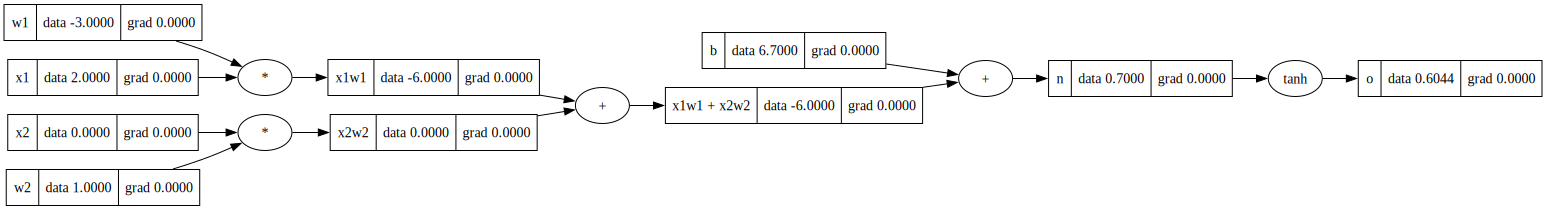

In [84]:
draw_dot(o)

In [85]:
o.backward()

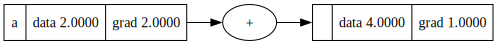

In [86]:
a = Value(2.0, label='a')
b = a + a

b.backward()
draw_dot(b)

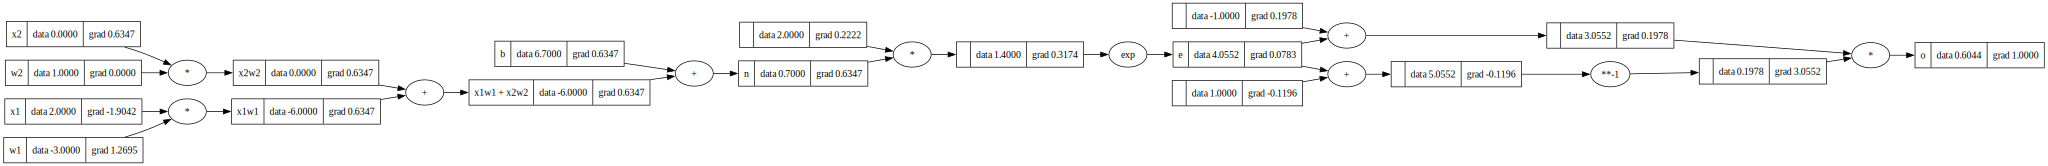

In [87]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.7, label='b')

x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

e = (2.0 * n).exp(); e.label = 'e'
o = (e - 1) / (e + 1); o.label = 'o'
o.backward()
draw_dot(o)

In [88]:
import torch

In [89]:
x1 = torch.tensor([2.0], requires_grad=True)
x2 = torch.tensor([0.0], requires_grad=True)
w1 = torch.tensor([-3.0], requires_grad=True)
w2 = torch.tensor([1.0], requires_grad=True)
b = torch.tensor([6.7], requires_grad=True)
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)
print(o.data.item())
o.backward()
print(x1.grad.item())
print(x2.grad.item())
print(w1.grad.item())
print(w2.grad.item())

0.6043676733970642
-1.9042192697525024
0.6347397565841675
1.269479513168335
0.0


In [90]:
import random

In [133]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [neuron(x) for neuron in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        self.layers = [Layer(nin, nouts[0])]
        self.layers += [Layer(nouts[i], nouts[i+1]) for i in range(len(nouts)-1)]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [134]:

x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.19546522749798034)

In [135]:
n.parameters()

[Value(data=-0.21577579807562053),
 Value(data=-0.17949831458976995),
 Value(data=-0.6139060813254467),
 Value(data=-0.6066075377494426),
 Value(data=-0.10935794206205318),
 Value(data=0.9412781107488228),
 Value(data=-0.6077892674833396),
 Value(data=0.5630367126960931),
 Value(data=0.778593202409039),
 Value(data=0.13945108287403896),
 Value(data=-0.9799649229761163),
 Value(data=0.3191876203283508),
 Value(data=-0.10309539627557807),
 Value(data=-0.5216093426632737),
 Value(data=0.610208182159335),
 Value(data=0.6830961635419597),
 Value(data=-0.9890174320739109),
 Value(data=0.47852136372756826),
 Value(data=0.12780553985360665),
 Value(data=0.615391356179509),
 Value(data=-0.7635950213028733),
 Value(data=-0.8299210942246182),
 Value(data=-0.604657466701308),
 Value(data=-0.1654165112314161),
 Value(data=0.7152714107355604),
 Value(data=-0.3520424837262024),
 Value(data=0.1244351432844717),
 Value(data=-0.527514512462606),
 Value(data=0.16343803484396657),
 Value(data=-0.582935513

In [160]:
xs = [
    [2.0, 3.0, -1.0],
    [1.0, -2.0, 0.0],
    [-1.0, 1.0, 2.0],
    [0.0, 2.0, -2.0]
]
ys = [1.0, -1.0, 1.0, -1.0]
ypred = [n(x) for x in xs]
ypred

[Value(data=0.9998768498752332),
 Value(data=-0.9999984337069421),
 Value(data=0.9999999797625496),
 Value(data=-0.9999519703684865)]

In [162]:
for k in range(10):
    ypred = [n(x) for x in xs]
    loss = sum((yi - ypi)**2 for yi, ypi in zip(ys, ypred))

    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    for p in n.parameters():
        p.data += -0.01 * p.grad

    print(k, loss.data)

0 1.7475027041654488e-08
1 1.7475004504558065e-08
2 1.747498196747988e-08
3 1.7474959430544564e-08
4 1.7474936893608042e-08
5 1.7474914356771778e-08
6 1.7474891819978306e-08
7 1.7474869283312437e-08
8 1.7474846746707437e-08
9 1.7474824210128548e-08


In [137]:
loss = sum((yi - ypi)**2 for yi, ypi in zip(ys, ypred))
loss

Value(data=4.101679971054561)

In [144]:
loss.backward()

In [139]:
n.layers[0].neurons[0].w[0].grad

1.127817437034986

In [140]:
n.layers[0].neurons[0].w[0].data

-0.21577579807562053

In [145]:
for p in n.parameters():
    p.data += -0.01 * p.grad

In [142]:
n.layers[0].neurons[0].w[0].data

-0.2270539724459704

In [143]:
ypred = [n(x) for x in xs]
loss = sum((yi - ypi)**2 for yi, ypi in zip(ys, ypred))
loss

Value(data=3.3898181587648133)

In [146]:
ypred = [n(x) for x in xs]
loss = sum((yi - ypi)**2 for yi, ypi in zip(ys, ypred))
loss

Value(data=2.1660443691637745)

In [157]:
loss.backward()
for p in n.parameters():
    p.data += -0.01 * p.grad
ypred = [n(x) for x in xs]

loss = sum((yi - ypi)**2 for yi, ypi in zip(ys, ypred))
print(ypred)
print(loss)

[Value(data=0.9905089747997394), Value(data=-0.999172721704675), Value(data=0.9999486895793341), Value(data=-0.9828557201936745)]
Value(data=0.0003846929115667461)
